# Blahut-Arimoto algorithm to compute the channel capacity for a given input-output response.

In [1]:
# Our numerical workhorses
import numpy as np
from sympy import mpmath
import scipy.optimize
import scipy.special
import scipy.integrate
import pandas as pd
import itertools
# Import libraries to parallelize processes
from joblib import Parallel, delayed

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib

# Seaborn, useful for graphics
import seaborn as sns

# Pickle is useful for saving outputs that are computationally expensive
# to obtain every time
import pickle

import os
import glob

# Import the utils for this project
import chann_cap_utils as chann_cap

chann_cap.set_plotting_style()

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

figdir = '../../fig/blahut_algorithm_channel_capacity/'
tmpdir = '../../tmp/'

# Input probability that maximizes the information transmited through a channel $P(m \mid C)$

Given the symmetry in the mutual information, i.e. $I(m;C)=I(C;m)$ the problem of transmiting a message can be studied from two perspectives:
1. Given a **fix input** $P(C)$ what is the input-output response $P(m \mid C)$ that would minimize the information subject to some average distortion $D$.
2. Given a **fix channel** $P(m \mid C)$ what is the input distribution that would maximize the mutual information.

The first view is treated by rate-distortion theory. The second point is the problem of computing the so-called information capacity of a channel. This information capacity is defined as
\begin{equation}
    C \equiv \max_{P(C)} I(C;m),
\end{equation}
where the maximum is taken over the space of probabilities $P(C)$. This means that a probability distribution $P^*(C)$ achieves capacity if it maximizes the information that can be transmitted through a fix channel.

This second view brings interesting points for our theory. On the one hand we are trying to evolve/design a circuit which could respond given a distribution of inputs. For this case rate-distortion theory tells us the minimum amount of information the channel should transmit from the input to maintain an average growth rate. On the other hand we have the full theoretical input-output function response for a given set of parameters. In this case it would be interesting to find which distribution of inputs would maximize the mutual information, and what would that maximum mutual information value be.

Luckly for us in his elegant paper Blahut not only developed the rate-distortion algorithm we implemented previously, but he also showed a simple iterataive algorithm that can approximate the distribution of inputs that achieves capacity.

In this script we will implement such algorithm and compute the maximum mutual information one can transmit through a simple repression circuit!

# Testing the implementation of the algorithm.

Before going all in with the implementation of the algorithm is worth testing it with a simple example.

We will test the regular Blahut-Arimoto (BA) algorithm as well as the accelerated BA algorithm from Matz and Duhamel 2005.

Let's implement the BA first.

In [2]:
def channel_capacity(QmC, epsilon=1E-3, info=1E4):
    '''
    Performs the Blahut-Arimoto algorithm to compute the channel capacity
    given a channel QmC.

    Parameters
    ----------
    QmC : array-like 
        definition of the channel with C inputs and m outputs.
    epsilon : float.
        error tolerance for the algorithm to stop the iterations. The smaller
        epsilon is the more precise the rate-distortion function is, but also
        the larger the number of iterations the algorithm must perform
    info : int.
        Number indicating every how many cycles to print the cycle number as
        a visual output of the algorithm.
    Returns
    -------
    C : float.
        channel capacity, or the maximum information it can be transmitted 
        given the input-output function.
    pc : array-like.
        array containing the discrete probability distribution for the input 
        that maximizes the channel capacity
    '''
    # initialize the probability for the input.
    pC = np.repeat(1 / QmC.shape[0], QmC.shape[0])
        
    # Initialize variable that will serve as termination criteria
    Iu_Il = 1
    
    loop_count = 0
    # Perform a while loop until the stopping criteria is reached
    while Iu_Il > epsilon:
        if (loop_count % info == 0) & (loop_count != 0):
            print('loop : {0:d}, Iu - Il : {1:f}'.format(loop_count, Iu_Il))
        loop_count += 1
        # compute the relevant quantities. check the notes on the algorithm
        # for the interpretation of these quantities
        # cC = exp(∑_m Qm|C log(Qm|C / ∑_c pC Qm|C))
        sum_C_pC_QmC = np.sum((pC * QmC.T).T, axis=0)
        QmC_log_QmC_sum_C_pC_QmC = QmC * np.log(QmC / sum_C_pC_QmC)
        # check for values that go to -inf because of 0xlog0
        QmC_log_QmC_sum_C_pC_QmC[np.isnan(QmC_log_QmC_sum_C_pC_QmC)] = 0
        QmC_log_QmC_sum_C_pC_QmC[np.isneginf(QmC_log_QmC_sum_C_pC_QmC)] = 0
        cC = np.exp(np.sum(QmC_log_QmC_sum_C_pC_QmC, axis=1))
       
        # I_L log(∑_C pC cC)
        Il = np.log(np.sum(pC * cC))
        
        # I_U = log(max_C cC)
        Iu = np.log(cC.max())
        
        # pC = pC * cC / ∑_C pC * cC
        pC = pC * cC / np.sum(pC * cC)
        
        Iu_Il = Iu - Il
        
    # convert from nats to bits
    Il = Il / np.log(2)
    return Il, pC, loop_count

Let's test the algorithm with the exercise that Matz proposes in his paper.

In [3]:
QmC = np.array([[0.7, 0.1], [0.2, 0.2], [0.1, 0.7]])

Il, pC, loop_count = channel_capacity(QmC.T, 1E-10)

print('Regular BA algorithm')
print('Mutual info:', Il)
print('Input distribution:', pC)
print('Iterations:', loop_count)

Regular BA algorithm
Mutual info: 0.36514844544
Input distribution: [ 0.5  0.5]
Iterations: 1


Now the channel that Arimoto proposes in his paper

In [4]:
QmC = np.array([[0.6, 0.7, 0.5], [0.3, 0.1, 0.05], [0.1, 0.2, 0.45]])

Il, pC, loop_count = channel_capacity(QmC.T, 1E-10)

print('Regular BA algorithm')
print('Mutual info:', Il)
print('Input distribution:', pC)
print('Iterations:', loop_count)

Regular BA algorithm
Mutual info: 0.161631860824
Input distribution: [  5.01735450e-01   1.41574430e-09   4.98264548e-01]
Iterations: 305


The algorithm converges to the value reported on the paper. So we know that this implementation is working.


# Computing theoretical channel capacity

Given the pre-computed distributions for different binding energies and different repressor copy numbers we can compute the theoretical channel capacity by feeding an input-output matrix $\mathbf{Q}_{g|c}$ to the algorithm.

Let's define a function that takes a data-frame with the pre-computed distributions, a list of inducer concentrations, and a total number of repressors per cell, and builds this transition matrix.

In [3]:
def theory_trans_matrix(df_prob, c, Rtot, tol=1E-20, **kwargs):
    '''
    Function that builds the transition matrix Qg|c for a series of
    concentrations c. It builds the matrix by using the tidy data-frames
    containing the pre-computed distributions.
    Parameters
    ----------
    df_prob : Pandas data frame.
        Data frame containing the pre-computed distributions. The data frame
        should contain 3 columns:
        1) repressor : number of repressors.
        2) protein   : number of proteins.
        3) prob      : probability of a protein copy number.
    c : array-like.
        Concentrations at which to evaluate the input-output function.
    Rtot : int.
        Total number of repressors per cell.
    tol : float.
        tolerance under which if a marginal probability for a protein is
        lower than that, that column is discarded.
    kwargs : arguments to be passed to the p_act function such as
        ka, ki :  dissociation constants
        epsilon : energy difference between active and inactive state
    Returns
    -------
    Qg|c : input output matrix in which each row represents a concentration
    and each column represents the probability of a protein copy number.
    '''
    # Convert the concentration to a numpy array
    c = np.array(c)
    
    # compute the p_active probabilities for each concentration
    pacts = chann_cap.p_act(c, **kwargs)
    pacts = np.unique(pacts)
    # Compute the number of repressors given this p_active. The
    # repressors will be round down for fractional number of repressors
    repressors = np.floor(Rtot * pacts)
    
    # Initialize matrix to save input-output function
    Qgc = np.zeros([len(c), len(df_prob.protein.unique())])
    
    # Loop through every repressor and add the probabilities to each
    # row of the Qg|c matrix
    for i, rep in enumerate(repressors):
        Qgc[i, :] =\
        df_prob[df_prob.repressor == rep].sort_values(by='protein').prob
    
    # Remove columns whose marginal protein probability is < tol
    prot_marginal = Qgc.sum(axis=0)
    return Qgc[:, prot_marginal > tol]

Having defined this function let's compute the channel capacity for the different repressor copy numbers.

In [4]:
# Define experimental concentrations in µM
c = [0, 0.1, 5, 10, 25, 50, 75, 100, 250, 500, 1000, 5000] # µM
# Define the MWC dissociation constants
mwc_param = dict(ka=141.52, ki=0.56061, epsilon=4.5)

# Define operators
operators = ['O1', 'O2', 'O3', 'Oid']
print(np.round(240 * chann_cap.p_act(C=c, **mwc_param)))
print(np.round(260 * chann_cap.p_act(C=c, **mwc_param)))

[ 237.  236.  119.   54.   14.    5.    3.    2.    1.    1.    0.    0.]
[ 257.  256.  129.   59.   15.    5.    3.    2.    1.    1.    0.    0.]


In [28]:
operators = ['O2', 'O1']#, 'Oid']
compute_channcap = True
if compute_channcap:
    # initialize data frame to save channel capacity computation
    df_channcap = pd.DataFrame(columns=['operator', 'repressor', 'channcap'])
    # loop through operators
    for op in operators:
        print(op)
        # Read pre-computed probabilities
        df_prob = pd.read_csv('../../data/csv_protein_dist/lnp_' + op + \
                              '_all_RBS1027_fit.csv',
                              header=0, index_col=0, comment='#')
        # Find the unique number of repressors to compute the channel capacity
        repressors = df_prob.repressor.unique()
        # Define function to compute in parallel the channel capacity
        def cc_parallel(r):
            # Build transition matrix
            Qgc = theory_trans_matrix(df_prob, c=c, Rtot=r, **mwc_param)
            # Compute the channel capacity with the Blahut-Arimoto algorithm
            cc = channel_capacity(Qgc, epsilon=1E-3)[0]
            return cc
            # generate a series with the relevant data
        # Run the function in parallel
        ccaps = Parallel(n_jobs=48)(delayed(cc_parallel)(r) for r in repressors)
        # Convert to tidy data frame
        ccaps = pd.DataFrame(ccaps, columns=['channcap'])
        ccaps.loc[:, 'operator'] = pd.Series([op] * len(ccaps))
        ccaps.loc[:, 'repressor'] = pd.Series(repressors)

        df_channcap = pd.concat([df_channcap, ccaps], axis=0)
    df_channcap.to_csv('../../data/csv_protein_dist/chann_cap_all_RBS1027_fit.csv',
                       index=False)

O2


/Users/razo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:42: RuntimeWarning: divide by zero encountered in log
/Users/razo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:42: RuntimeWarning: invalid value encountered in multiply
/Users/razo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:42: RuntimeWarning: divide by zero encountered in log
/Users/razo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:42: RuntimeWarning: divide by zero encountered in log
/Users/razo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:42: RuntimeWarning: invalid value encountered in multiply
/Users/razo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:42: RuntimeWarning: invalid value encountered in multiply
/Users/razo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:42: RuntimeWarning: divide by zero encountered in log
/Users/razo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:42: RuntimeWarning: divide by zero encount

O1


/Users/razo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:42: RuntimeWarning: divide by zero encountered in log
/Users/razo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:42: RuntimeWarning: divide by zero encountered in log
/Users/razo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:42: RuntimeWarning: invalid value encountered in multiply
/Users/razo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:42: RuntimeWarning: invalid value encountered in multiply
/Users/razo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:42: RuntimeWarning: divide by zero encountered in log
/Users/razo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:42: RuntimeWarning: divide by zero encountered in log
/Users/razo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:42: RuntimeWarning: divide by zero encountered in log
/Users/razo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:42: RuntimeWarning: divide by zero encountered

In [17]:
test = [len(x.protein.unique()) for g, x in df_prob.groupby('repressor')]

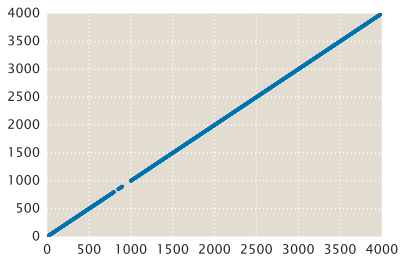

In [27]:
plt.plot(df_prob[df_prob.repressor==0].protein, marker='.', lw=0)

Having computed the channel capacity let's look at the plot!

In [29]:
df_channcap = pd.read_csv(\
              '../../data/csv_protein_dist/chann_cap_all_RBS1027_fit.csv',
                         header=0, index_col=None)
df_channcap.head()

,channcap,operator,repressor
0,0.000000,O2,0.0
1,0.000000,O2,1.0
2,0.320435,O2,2.0
3,0.591408,O2,3.0
4,0.760916,O2,4.0


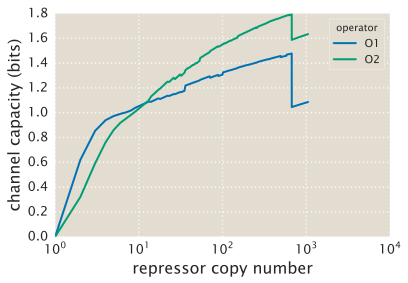

In [30]:
df_group = df_channcap.groupby('operator')

fig, ax = plt.subplots(1, 1)
for group, data in df_group:
    ax.plot(data.repressor, data.channcap, label=group)

ax.set_xlabel('repressor copy number')
ax.set_ylabel('channel capacity (bits)')
ax.set_xscale('log')
ax.legend(loc=0, title='operator')